**CS-GY 6613, Artificial Intelligence, Spring 2020**<br/>
**New York University Tandon School of Engineering**<br/>
**Course Project - 1**<br/>
**Name - Durga Prasad Reddy Kasireddy**<br/>
**Net ID - dpk290**<br/>

Implemented the following:
1. Data Ingestion, Preprocessing
2. Feature Selection - Pearson Correlation Filter method
3. Algorithm Choice - Softmax regression using Deep Neural Networks
4. Model Architecture, Regularization
5. Cross Validation - K-fold
6. Accuracy reporting in different methods

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/career-con-2019/X_train.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_test.csv


**Importing Necessary libraries**

In [2]:
from sklearn.model_selection import train_test_split, KFold
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
import statistics 
from statistics import mode, mean


Using TensorFlow backend.


In [3]:
# read Kaggle datasets
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')


***Observations***<br/>
Notice that the number of samples for X and Y are different.



In [4]:
X_train.head()

row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.74857                 2.1030   
1            0.003385                0.33995                 1.5064   
2           -0.005978               -0.26429                 1.5922   
3           -0.008974                0.42684                 1.0993   
4            0.005245               -0.50969                 1.4689   

   linear_acceleration_Z  
0                -9.7532  
1                -9.4128  
2                -8.7267  
3               -10.0960  
4               -10.4410

In [5]:
# Number of samples are different for x and y
# Check how many different classes are there in the dataset

print("X train shape is ", X_train.shape)
print("Y train shape is ", y_train.shape)
print(y_train['surface'].unique())

X train shape is  (487680, 13)
Y train shape is  (3810, 3)
['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']


Plotting number of surfaces

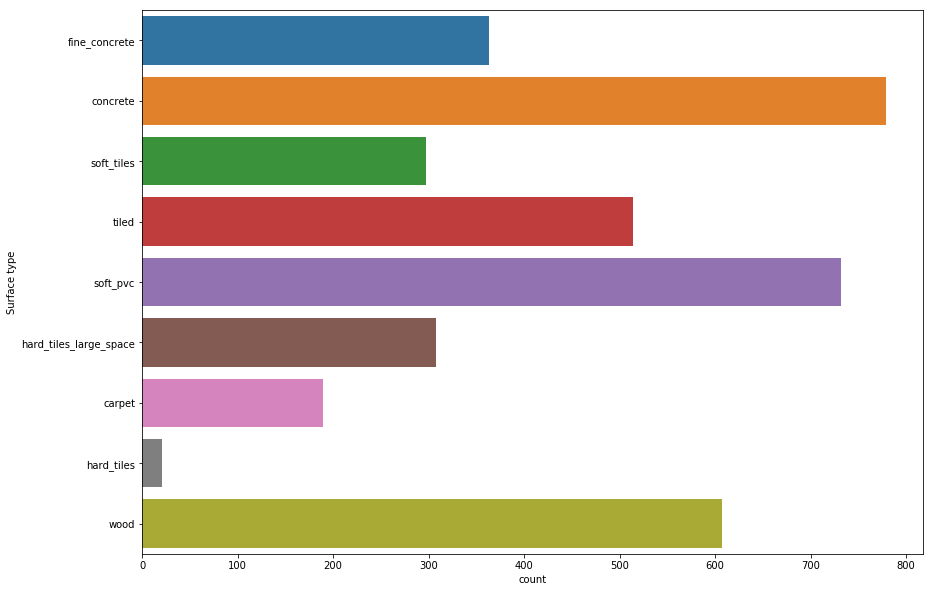

In [6]:
a, graph = plt.subplots(figsize=(14, 10))
graph = sns.countplot(y='surface', data = y_train)
graph.set_ylabel("Surface type")
plt.show()


Encoding the labels of y_train to numbers.

In [7]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])
print(y_train['surface'])

0       2
1       1
2       1
3       1
4       6
       ..
3805    7
3806    8
3807    2
3808    7
3809    5
Name: surface, Length: 3810, dtype: int64


Train and Test data as per the instructions

In [8]:
samples = 20
time_series = 128
start_x = X_train.shape[0] - samples*time_series
X_train_new, X_test_new = X_train.iloc[:start_x], X_train.iloc[start_x:]
# split y_train
start_y = y_train.shape[0] - samples
y_train_new, y_test_new = y_train.iloc[:start_y], y_train.iloc[start_y:]

Every series id in X_train_new has 128 measurememts and this series id is a foreign key to the series id in y_train_new. 
So, I will join the X_train_new and y_train_new to make a table called "TRAINING" with 485120 samples.<br/>

I will use TRAINING table to generate my train and validation set for Cross Validation and model fitting


In [9]:
# Split data into Training and Validation
X_train_new = X_train_new.drop(['row_id', "measurement_number"], axis=1)
y_train_new = y_train_new.drop(['group_id'], axis=1)

TRAINING = X_train_new.join(y_train_new, on='series_id', rsuffix='_')
print("Just after joining tables")
display(TRAINING)
print(TRAINING)

# We no longer need series_id in our combined data

TRAINING.drop('series_id', axis = 1, inplace = True)
classification = TRAINING['surface']
classification = to_categorical(classification)

TRAINING.drop('series_id_', axis=1, inplace=True)
print("After dropping columns")
print(TRAINING.shape)
TRAINING.head()


Just after joining tables


series_id  orientation_X  orientation_Y  orientation_Z  orientation_W  \
0               0       -0.75853       -0.63435       -0.10488      -0.105970   
1               0       -0.75853       -0.63434       -0.10490      -0.106000   
2               0       -0.75853       -0.63435       -0.10492      -0.105970   
3               0       -0.75852       -0.63436       -0.10495      -0.105970   
4               0       -0.75852       -0.63435       -0.10495      -0.105960   
...           ...            ...            ...            ...            ...   
485115       3789       -0.61258       -0.77649       -0.11988      -0.086228   
485116       3789       -0.61309       -0.77609       -0.11983      -0.086299   
485117       3789       -0.61362       -0.77567       -0.11978      -0.086404   
485118       3789       -0.61412       -0.77527       -0.11975      -0.086465   
485119       3789       -0.61460       -0.77488       -0.11975      -0.086523   

        angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
0                 0.107650            0.017561            0.000767   
1                 0.067851            0.029939            0.003385   
2                 0.007275            0.028934           -0.005978   
3                -0.013053            0.019448           -0.008974   
4                 0.005135            0.007652            0.005245   
...                    ...                 ...                 ...   
485115           -0.019982           -0.132110            0.514850   
485116           -0.010157           -0.142460            0.504710   
485117           -0.011636           -0.141630            0.505770   
485118           -0.018504           -0.125560            0.497730   
485119           -0.029907           -0.111770            0.490680   

        linear_acceleration_X  linear_acceleration_Y  linear_acceleration_Z  \
0                    -0.74857                 2.1030                -9.7532   
1                     0.33995                 1.5064                -9.4128   
2                    -0.26429                 1.5922                -8.7267   
3                     0.42684                 1.0993               -10.0960   
4                    -0.50969                 1.4689               -10.4410   
...                       ...                    ...                    ...   
485115               -0.53447                 2.7850                -9.8394   
485116               -0.63661                 2.8357                -9.7078   
485117               -0.17942                 3.0611                -9.4939   
485118               -0.31623                 3.2085                -9.3682   
485119                0.12198                 3.2771                -9.3710   

        series_id_  surface  
0                0        2  
1                0        2  
2                0        2  
3                0        2  
4                0        2  
...            ...      ...  
485115        3789        8  
485116        3789        8  
485117        3789        8  
485118        3789        8  
485119        3789        8  

[485120 rows x 13 columns]

        series_id  orientation_X  orientation_Y  orientation_Z  orientation_W  \
0               0       -0.75853       -0.63435       -0.10488      -0.105970   
1               0       -0.75853       -0.63434       -0.10490      -0.106000   
2               0       -0.75853       -0.63435       -0.10492      -0.105970   
3               0       -0.75852       -0.63436       -0.10495      -0.105970   
4               0       -0.75852       -0.63435       -0.10495      -0.105960   
...           ...            ...            ...            ...            ...   
485115       3789       -0.61258       -0.77649       -0.11988      -0.086228   
485116       3789       -0.61309       -0.77609       -0.11983      -0.086299   
485117       3789       -0.61362       -0.77567       -0.11978      -0.086404   
485118       3789       -0.61412       -0.77527       -0.11975      -0.086465   
485119       3789       -0.61460       -0.77488       -0.11975      -0.086523   

        angular_velocity_X 

orientation_X  orientation_Y  orientation_Z  orientation_W  \
0       -0.75853       -0.63435       -0.10488       -0.10597   
1       -0.75853       -0.63434       -0.10490       -0.10600   
2       -0.75853       -0.63435       -0.10492       -0.10597   
3       -0.75852       -0.63436       -0.10495       -0.10597   
4       -0.75852       -0.63435       -0.10495       -0.10596   

   angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
0            0.107650            0.017561            0.000767   
1            0.067851            0.029939            0.003385   
2            0.007275            0.028934           -0.005978   
3           -0.013053            0.019448           -0.008974   
4            0.005135            0.007652            0.005245   

   linear_acceleration_X  linear_acceleration_Y  linear_acceleration_Z  \
0               -0.74857                 2.1030                -9.7532   
1                0.33995                 1.5064                -9.4128   
2               -0.26429                 1.5922                -8.7267   
3                0.42684                 1.0993               -10.0960   
4               -0.50969                 1.4689               -10.4410   

   surface  
0        2  
1        2  
2        2  
3        2  
4        2

In [10]:
plt.figure(figsize=(12,10))
corr = TRAINING.corr(method = 'pearson')
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

From the heatmap, we can observe that the features 'angular_velocity_Y' and 'angular_velocity_Z' have comparitively high correlation 

In [11]:
#Correlation with output variable
corr_target = abs(corr['surface'])
#Selecting highly correlated features
relevant_features = corr_target[corr_target>0.01]
relevant_features

# Observations :
# orientation_Z and orientation_Y are strongly correlated
# orientation_X and orientation_W are strongly correlated
# angular_velocity_Y and angular_velocity_ are negatively correlated


orientation_X         0.076518
orientation_Z         0.011701
orientation_W         0.074003
angular_velocity_Y    0.124661
angular_velocity_Z    0.156024
surface               1.000000
Name: surface, dtype: float64

Since the feature 'linear_acceleration_Z' has very low correlation with our prediction 'surface' I am removing that feature 

In [12]:
TRAINING.drop(['linear_acceleration_Z'], axis=1)
#'orientation_Y', 'angular_velocity_X', 

orientation_X  orientation_Y  orientation_Z  orientation_W  \
0            -0.75853       -0.63435       -0.10488      -0.105970   
1            -0.75853       -0.63434       -0.10490      -0.106000   
2            -0.75853       -0.63435       -0.10492      -0.105970   
3            -0.75852       -0.63436       -0.10495      -0.105970   
4            -0.75852       -0.63435       -0.10495      -0.105960   
...               ...            ...            ...            ...   
485115       -0.61258       -0.77649       -0.11988      -0.086228   
485116       -0.61309       -0.77609       -0.11983      -0.086299   
485117       -0.61362       -0.77567       -0.11978      -0.086404   
485118       -0.61412       -0.77527       -0.11975      -0.086465   
485119       -0.61460       -0.77488       -0.11975      -0.086523   

        angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
0                 0.107650            0.017561            0.000767   
1                 0.067851            0.029939            0.003385   
2                 0.007275            0.028934           -0.005978   
3                -0.013053            0.019448           -0.008974   
4                 0.005135            0.007652            0.005245   
...                    ...                 ...                 ...   
485115           -0.019982           -0.132110            0.514850   
485116           -0.010157           -0.142460            0.504710   
485117           -0.011636           -0.141630            0.505770   
485118           -0.018504           -0.125560            0.497730   
485119           -0.029907           -0.111770            0.490680   

        linear_acceleration_X  linear_acceleration_Y  surface  
0                    -0.74857                 2.1030        2  
1                     0.33995                 1.5064        2  
2                    -0.26429                 1.5922        2  
3                     0.42684                 1.0993        2  
4                    -0.50969                 1.4689        2  
...                       ...                    ...      ...  
485115               -0.53447                 2.7850        8  
485116               -0.63661                 2.8357        8  
485117               -0.17942                 3.0611        8  
485118               -0.31623                 3.2085        8  
485119                0.12198                 3.2771        8  

[485120 rows x 10 columns]

Since this is a multi-class classification problem, I chose to perform a softmax regression using Deep Neural Networks. It is a fair choice because softmax gives a probability distribution of each sample belonging to a class<br/>

**Architecture**<br/>
Since the data is not linearly seperable, I had to use more than 2 layers. The number of neurons in each layer, dropout, number of layers have been decided to be the values I used after a lot of experimenting between various combinations. This configuration got me a better result <br/>

My Network architecture consists of a total of 4 layers. One input, one output and 2 hidden layers. <br/>
Regularization - I included a Dropout of 0.1 for layer 2 (shutting down some neurons so that weights are a little spread out)

I used Rectified Linear Units (ReLU) activation function for all the layers except the output layer. There are multiple reasons behind this is ReLU is computationally efficient (it will just take max between x and 0) than sigmoid or tanh.<br/>
It has no vanishing gradient problem unlike other activation functions. <br/>




In [13]:
# Cross Validation Algorithm, using K-Fold
kfold_train = TRAINING

kfold_train = kfold_train.to_numpy()
kfoldTRAINING = KFold(10, False)

accuracies = []
for training, testing in kfoldTRAINING.split(kfold_train):
    kfold_xtrain = kfold_train[training]
    kfold_xvalidate = kfold_train[testing]

    kfold_ytrain = kfold_xtrain.T
    kfold_ytrain = kfold_ytrain[10]
  
    kfold_yvalidate = kfold_xvalidate.T
    kfold_yvalidate = kfold_yvalidate[10]

    kfold_x_train = pd.DataFrame(data = kfold_xtrain[:])
    kfold_x_train.drop(10, axis = 1, inplace = True)
    kfold_y_train = pd.DataFrame(data = kfold_ytrain[:])
    kfold_y_train = to_categorical(kfold_y_train)
    

    kfold_x_validate = pd.DataFrame(data = kfold_xvalidate[:])
    kfold_x_validate.drop(10, axis = 1, inplace = True)
    kfold_y_validate = pd.DataFrame(data = kfold_yvalidate[:])  
    kfold_y_validate = to_categorical(kfold_y_validate)

    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim = kfold_x_train.shape[1]))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(0.001), metrics = ['accuracy'])
    model.summary()
    
    model.fit(kfold_x_train.values, kfold_y_train, batch_size = 64, validation_data=(kfold_x_train.values, kfold_y_train), epochs = 20, verbose=1)
    temp = model.evaluate(kfold_x_train.values, kfold_y_train)
    accuracies.append(temp[1])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 189       
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
Train on 436608 samples, validate on 436608 samples
Epoch 1/20
436608/436608 [==============================] - 21s 47

I used Kfold Cross Validation Strategy for an averaged accuracy metric that is more robust.<br/>
The standard batch_sizes are 32, 64, 128. I used batch_size = 64

In [14]:
avgCV = statistics.mean(accuracies)
print("The average accuracy after k-fold cross validation is ", avgCV)

The average accuracy after k-fold cross validation is  0.7231922090053559


I split the TRAINING table into 80-20 for training and validation sets to train my model.

In [15]:
# The 'surface' column is no longer required
TRAINING.drop('surface', axis=1, inplace=True)
X_model_train, X_validate, y_model_train, y_validate = train_test_split(TRAINING, classification, test_size=0.2, random_state=0)


Since I have used OneHot Encoding for the output labels, I will use loss function = 'categorical_crossentropy' instead of 'sparse_categorical_crossentropy'. The reason behind OneHot Encoding and 'categorical_crossentropy' is there is no possibility of information loss unlike 'sparse_categorical_crossentropy'

I use Adam optimizer with learning rate = 0.001 instead of Gradient Descent because Adam implements both gradient descent and also gives a short-term memory to the optimizer. Momentum in Adam helps the algorithm get to the local minimum faster.

In [16]:
model = Sequential()
model.add(Dense(20, activation='relu', input_dim = X_model_train.shape[1]))
model.add(Dense(20, activation='relu'))
model.add((Dropout(0.1)))
model.add(Dense(20, activation='relu'))
model.add(Dense(9, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(0.001), metrics = ['accuracy'])
model.summary()



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_44 (Dense)             (None, 9)                 189       
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


**Behind the Architecture, What is happening?**<br/>
We have 388096 samples in our training set. I chose a batch_size = 64 and epochs = 120<br/>
This means the dataset will be divided into 64 batches, each with 6064 samples. The model weights will be updated after each batch which implies One epoch will involve 64 batches/updates to the model.<br/>

The model will be passed through the whole data set 100 times, which is a total of 7680 batches during the entire training process.

In [17]:
history = model.fit(X_model_train.values, y_model_train, batch_size = 64, validation_data=(X_validate.values, y_validate), epochs = 120, verbose=1)


Train on 388096 samples, validate on 97024 samples
Epoch 1/120
388096/388096 [==============================] - 13s 33us/step - loss: 1.5948 - accuracy: 0.4046 - val_loss: 1.2984 - val_accuracy: 0.5461
Epoch 2/120
388096/388096 [==============================] - 13s 32us/step - loss: 1.2635 - accuracy: 0.5430 - val_loss: 1.1102 - val_accuracy: 0.6018
Epoch 3/120
388096/388096 [==============================] - 13s 33us/step - loss: 1.1395 - accuracy: 0.5833 - val_loss: 1.0055 - val_accuracy: 0.6317
Epoch 4/120
388096/388096 [==============================] - 13s 33us/step - loss: 1.0728 - accuracy: 0.6055 - val_loss: 0.9623 - val_accuracy: 0.6410
Epoch 5/120
388096/388096 [==============================] - 13s 33us/step - loss: 1.0354 - accuracy: 0.6180 - val_loss: 0.9213 - val_accuracy: 0.6592
Epoch 6/120
388096/388096 [==============================] - 13s 33us/step - loss: 1.0102 - accuracy: 0.6267 - val_loss: 0.8966 - val_accuracy: 0.6610
Epoch 7/120
388096/388096 [================

In [18]:

X_test_new = X_test_new.drop(['series_id', "measurement_number", "row_id"], axis=1)

In [19]:
predictions = model.predict_classes(X_test_new.values)

**Accuracy vs Number of epochs plot**

In [20]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


The accuracy on my validation set is 80%

**Model loss vs Number of epochs plot**

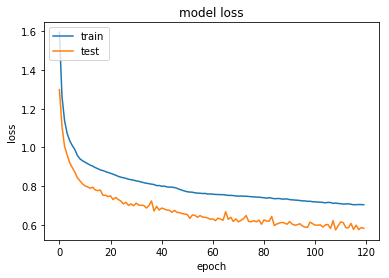

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I defined a function my_mode which returns mode of a list. In case of ties, it randomly chooses one among all the ties

In [22]:
import random
def my_mode(array):
    most = max(list(map(array.count, array)))
    return random.choice(list(set(filter(lambda x: array.count(x) == most, array))))


**Method - 1 for reporting accuracy** <br/>
Since every 128 predictions correspond to a single sample, I will take most frequent prediction among those 128 and return that label. In case of ties, I return one label among those modes randomly

In [23]:

finalPredictions = []
i = 0
while(i < len(predictions)):
    j = 0
    temp = []
    while(j < 128):
        temp.append(predictions[i])
        j = j + 1
    
        i = i + 1
    a = my_mode(temp)
    finalPredictions.append(a)

In [24]:
#print(y_test_new['surface'], finalPredictions)
actualValues = y_test_new['surface']
print(actualValues)

valuess = actualValues.to_numpy()
acc = 0
for i in range(len(valuess)):
    if valuess[i] == finalPredictions[i]:
        acc = acc + 1
print(acc)
acc = acc / len(valuess)
print("Accuracy reported using mode method ", acc)

3790    4
3791    1
3792    5
3793    7
3794    4
3795    1
3796    8
3797    2
3798    1
3799    7
3800    2
3801    4
3802    7
3803    8
3804    7
3805    7
3806    8
3807    2
3808    7
3809    5
Name: surface, dtype: int64
15
Accuracy reported using mode method  0.75


**Second method to report Accuracy on test data**<br/>
I fit the test data again on my model but this time, I join the X_test_new and y_test_new (as I did previously to create TRAINING table) and report the accuracy given by my model.

In [25]:

# read Kaggle datasets
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')

le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])
#print(y_train['surface'])

samples = 20
time_series = 128
start_x = X_train.shape[0] - samples*time_series
X_train_new, X_test_new = X_train.iloc[:start_x], X_train.iloc[start_x:]
# split y_train
start_y = y_train.shape[0] - samples
y_train_new, y_test_new = y_train.iloc[:start_y], y_train.iloc[start_y:]

In [26]:
X_test_new = X_test_new.drop(["measurement_number", "row_id"], axis=1)
#X_test_new.head(21)
#newPrediction = X_test_new.join(y_test_new, on='')
y_test_new = y_test_new.drop(["group_id"], axis = 1)

In [27]:
newPrediction = X_test_new.join(y_test_new, on='series_id', rsuffix = '_')
#TRAINING = X_train_new.join(y_train_new, on='series_id', rsuffix='_')
newPrediction.head(21)
newPrediction.drop(["series_id_"], axis = 1)

newYtest = newPrediction['surface']


#newYtest = to_categorical(newYtest)

In [28]:
print(newYtest.shape)
X_test_new.drop(["series_id"], axis = 1, inplace = True)
print(X_test_new.shape)

(2560,)
(2560, 10)


In [29]:
anotherPrediction = model.predict_classes(X_test_new.values)

In [30]:
print(anotherPrediction)

[4 4 4 ... 5 5 5]


In [31]:
newYtest = newYtest.to_numpy()
print(newYtest)

[4 4 4 ... 5 5 5]


In [32]:
accuracy = 0
for i in range(len(anotherPrediction)):
    if anotherPrediction[i] == newYtest[i]:
        accuracy = accuracy + 1
print(accuracy)
accuracy = accuracy / len(anotherPrediction)
print(accuracy)

2035
0.794921875


***Results***<br/>
K-fold Cross Validation accuracy when k = 10 and 20 epochs is 73% (Due to computational power limitation, I had to decrease the number of epochs from 100 to 20. But the Graphs plotted show that the accuracy can go till 80%) <br/>

Generalization error on my validation set = 20% (Cross Validation suggested similar statistics)<br/>
Accuracy on test data using mode method = 80% (16/20 samples classified correctly)<br/>
Accuracy on test data after increasing test data dimension and feeding the new input to my model is 77%